  calendar_dt                       id_employee  useful_calls_fact  \
0  2024-10-22  b85a5824cc3411e3429bd49054ffcc17               1225   
1  2024-10-22  611677896b031565a86d510977572ddf                  0   
2  2024-09-20  3506d80afbdc2f1ddcee2ce65e7d82ee                  0   
3  2024-12-25  a497350c6c8542c1e79ae2b83e6c782d              11483   
4  2024-09-20  34f30cdf1ab7f0195a74ef15963c29a5               1426   

   useful_chats_fact  avail_calls_fact  avail_chats_fact  \
0                  0              2542                 0   
1                  0                 0                 0   
2              21235                 0               372   
3              27466                 3               130   
4              30649               184              2119   

   avail_chat_call_fact  break_fact  education_fact  additional_fact  ...  \
0                     0           0           27598                0  ...   
1                     0           0               0             

C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


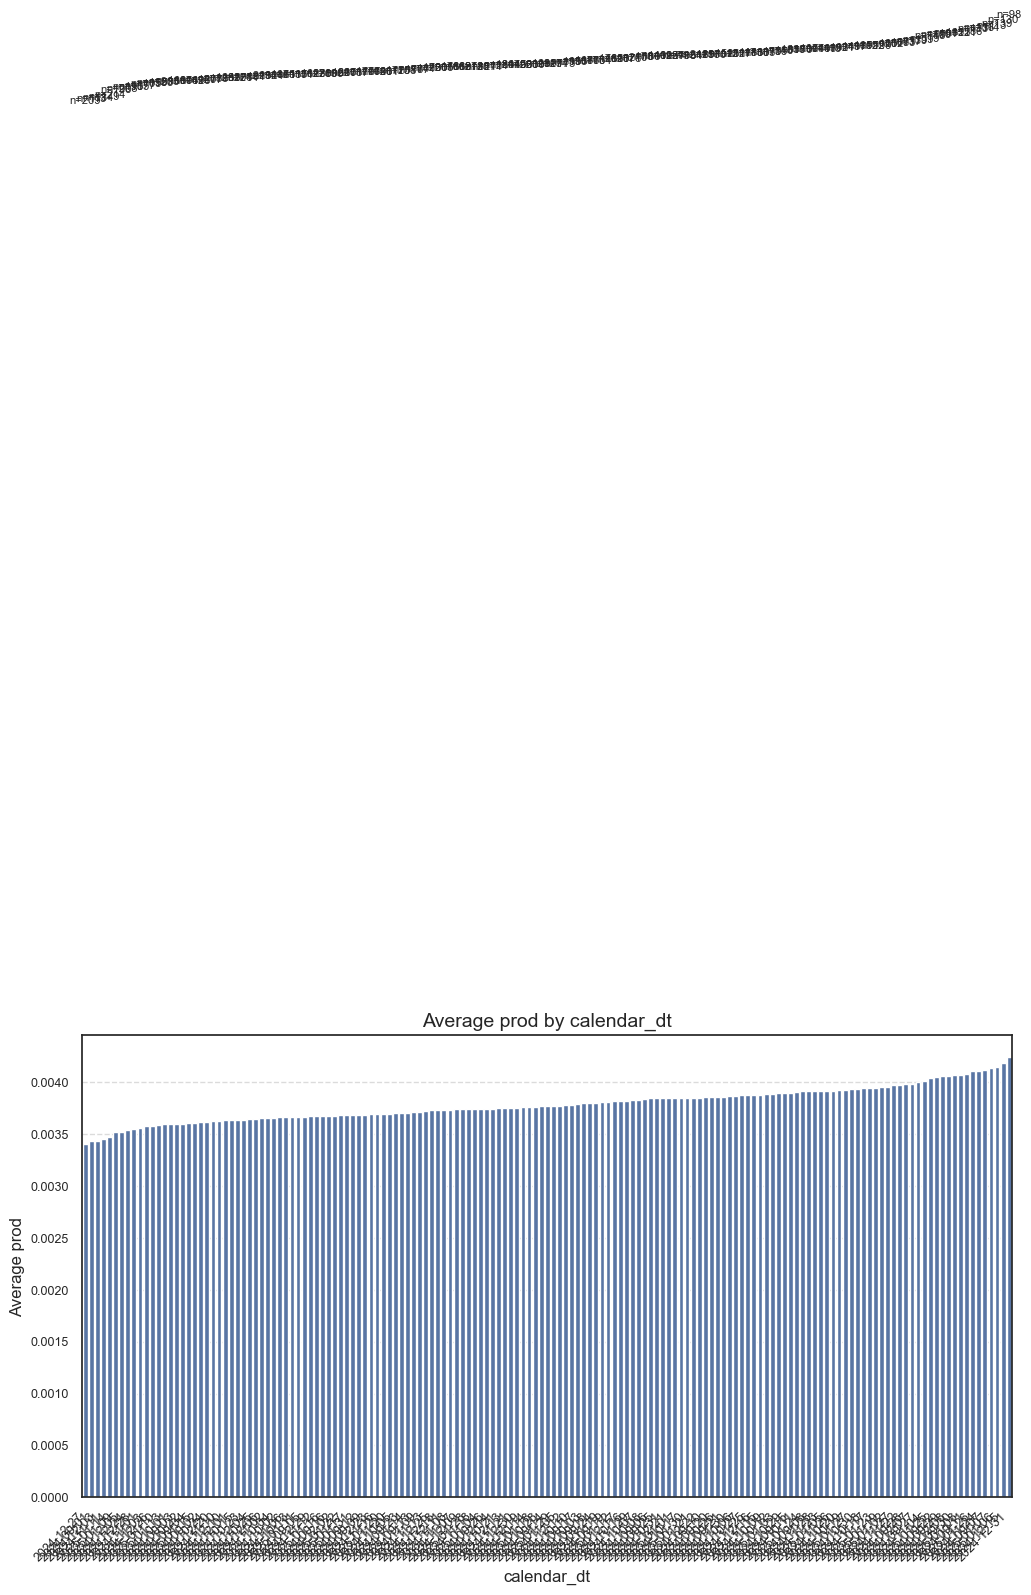

Analyzing: id_employee
Analyzing: useful_calls_fact
Analyzing: useful_chats_fact
Analyzing: avail_calls_fact
Analyzing: avail_chats_fact
Analyzing: avail_chat_call_fact
Analyzing: break_fact
Analyzing: education_fact
Analyzing: additional_fact
Analyzing: all_system_fact
Analyzing: work_activity_plan
Analyzing: break_plan


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should 

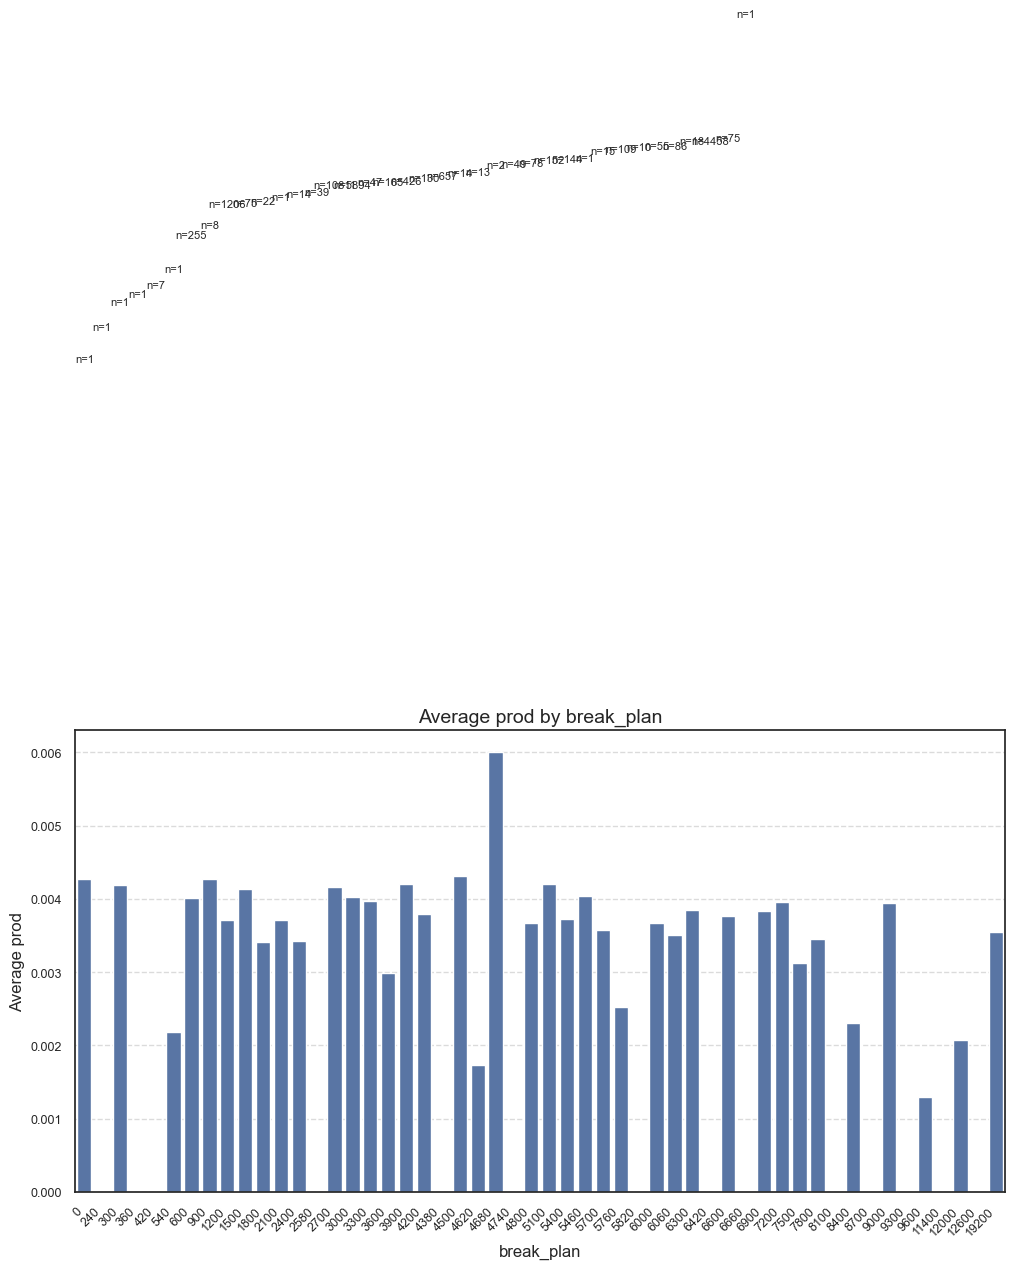

Analyzing: education_plan
Analyzing: additional_plan


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should 

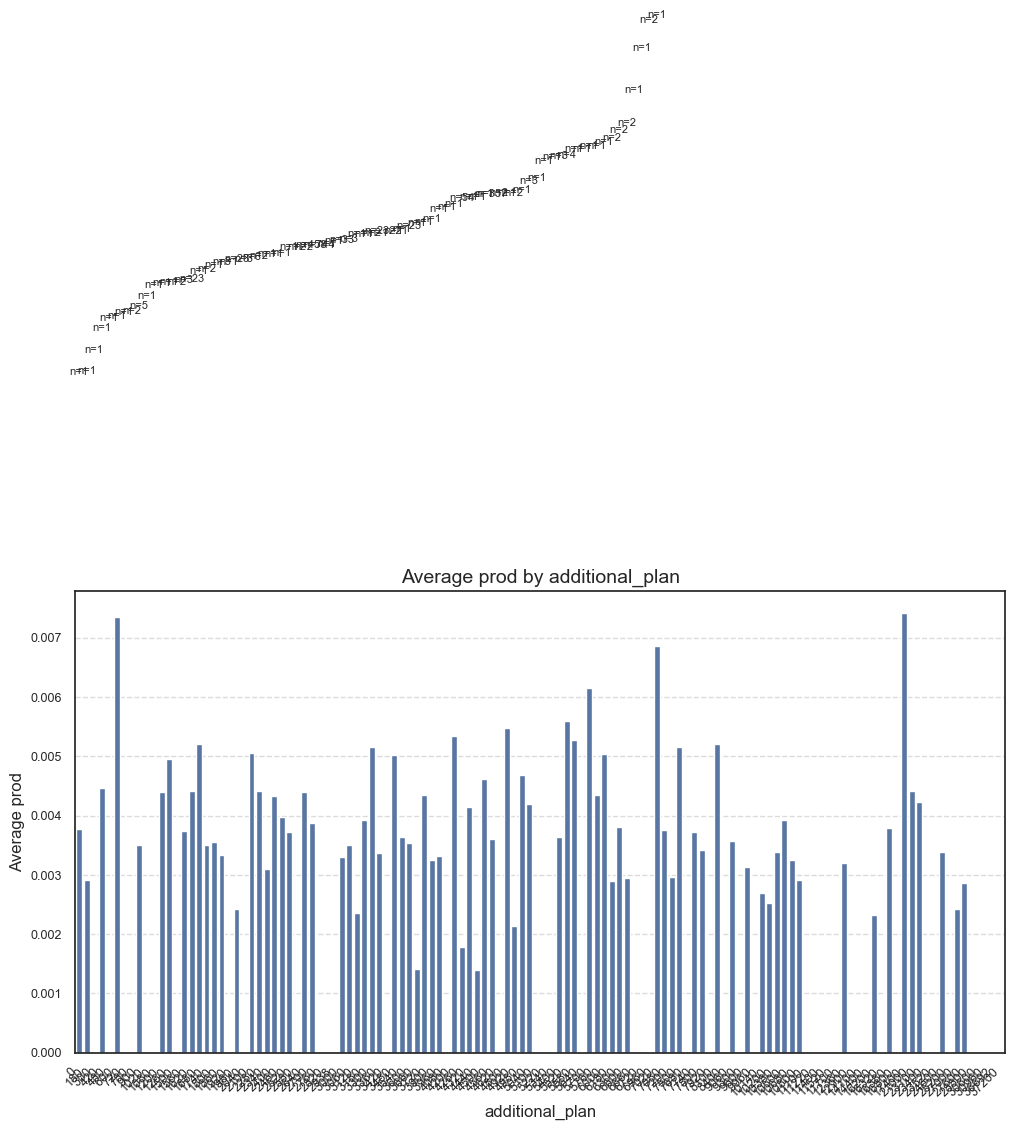

C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Analyzing: all_smena_plan
Analyzing: business_line


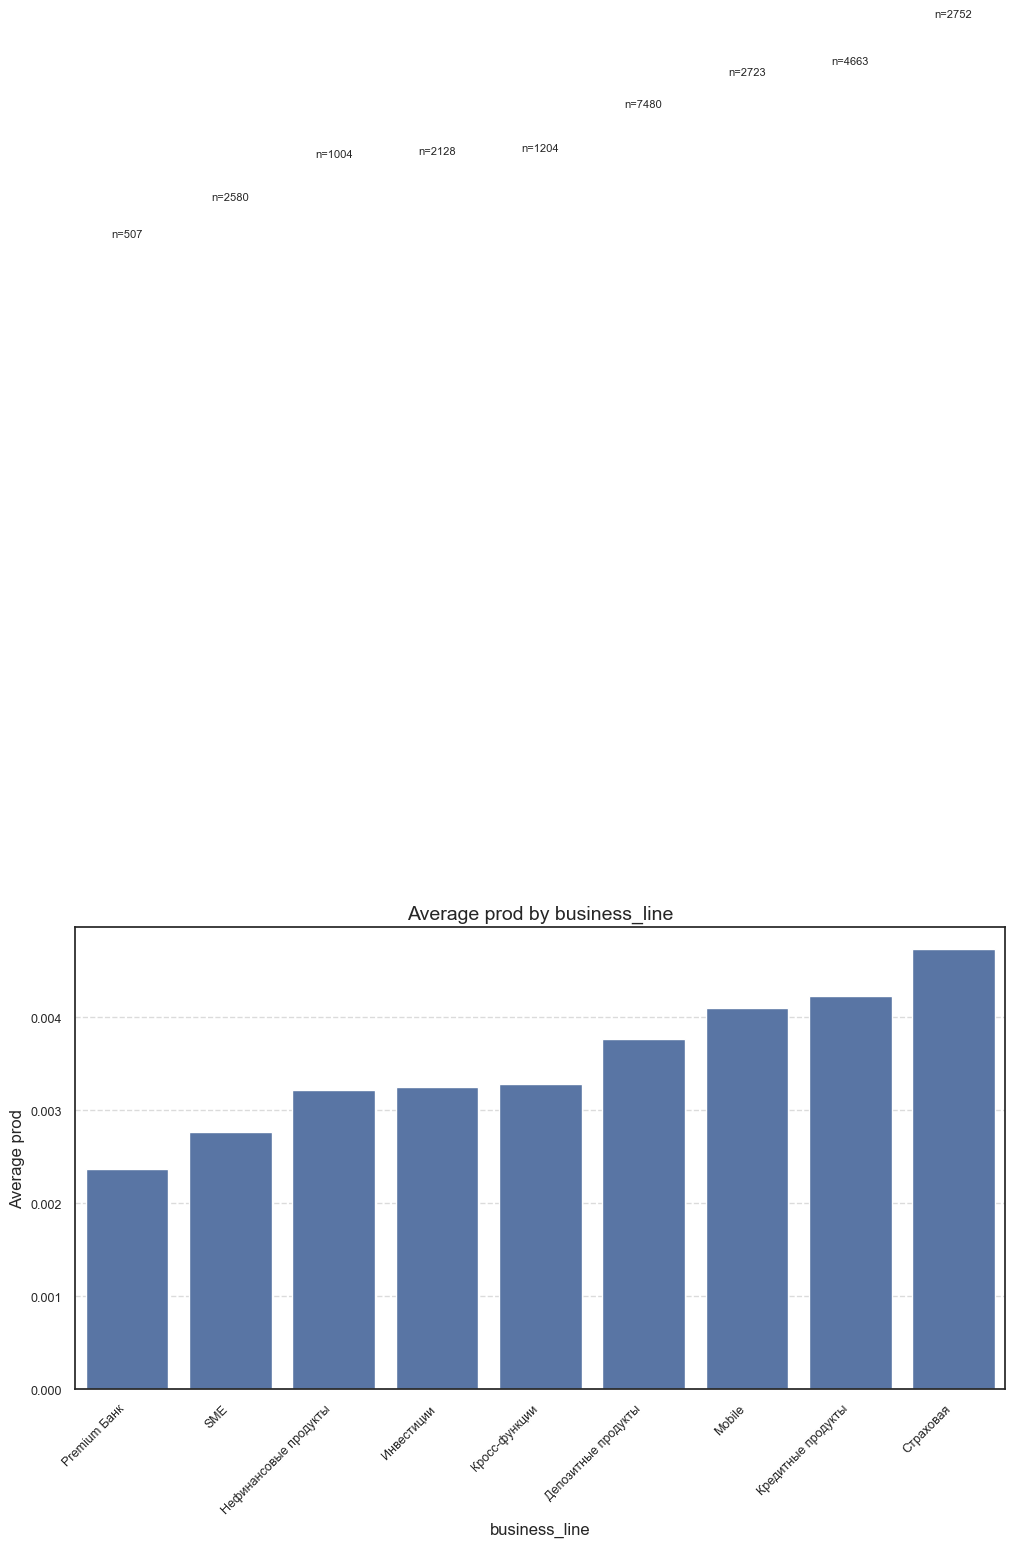

Analyzing: napravlenie


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


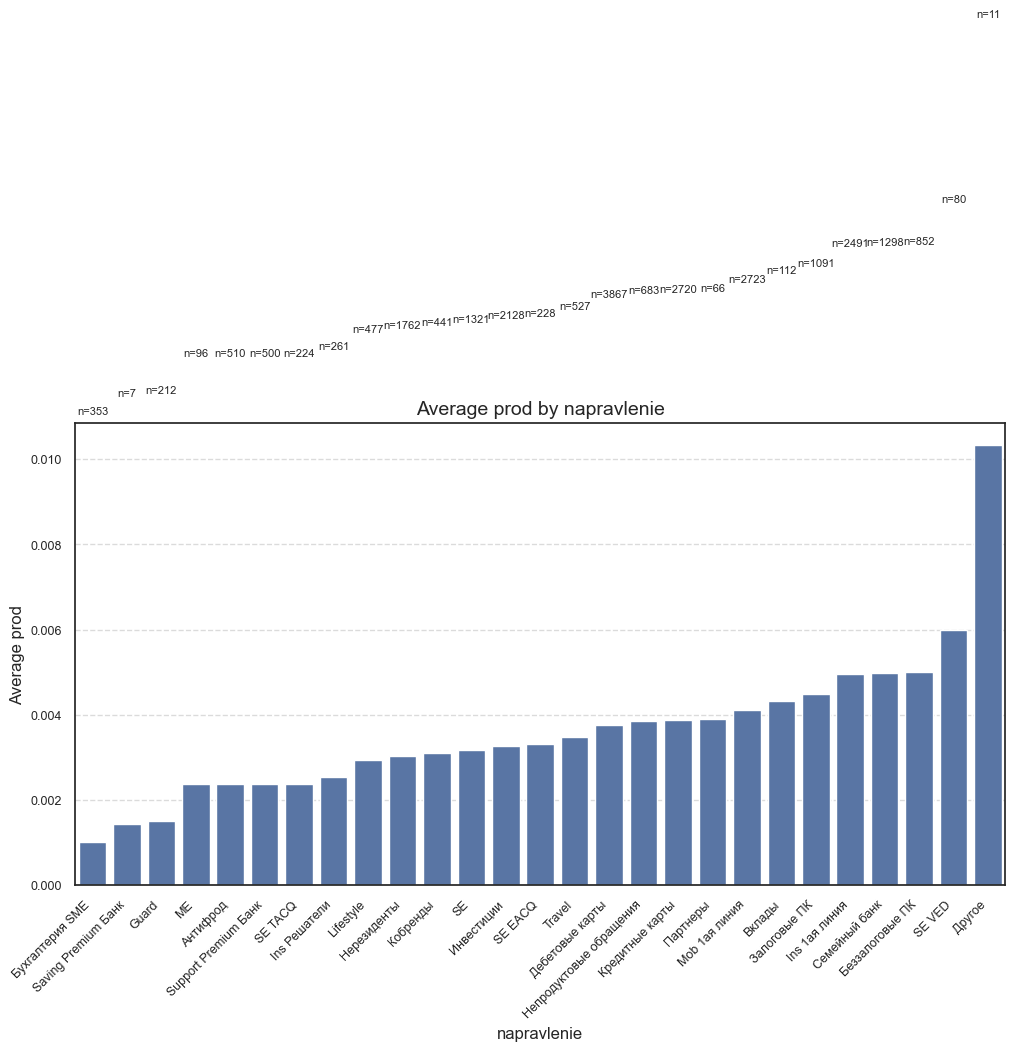

Analyzing: grid_group


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


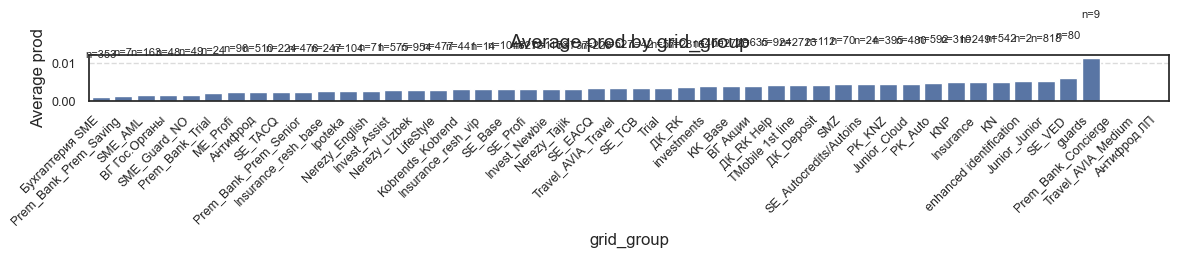

Analyzing: skill_group


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should 

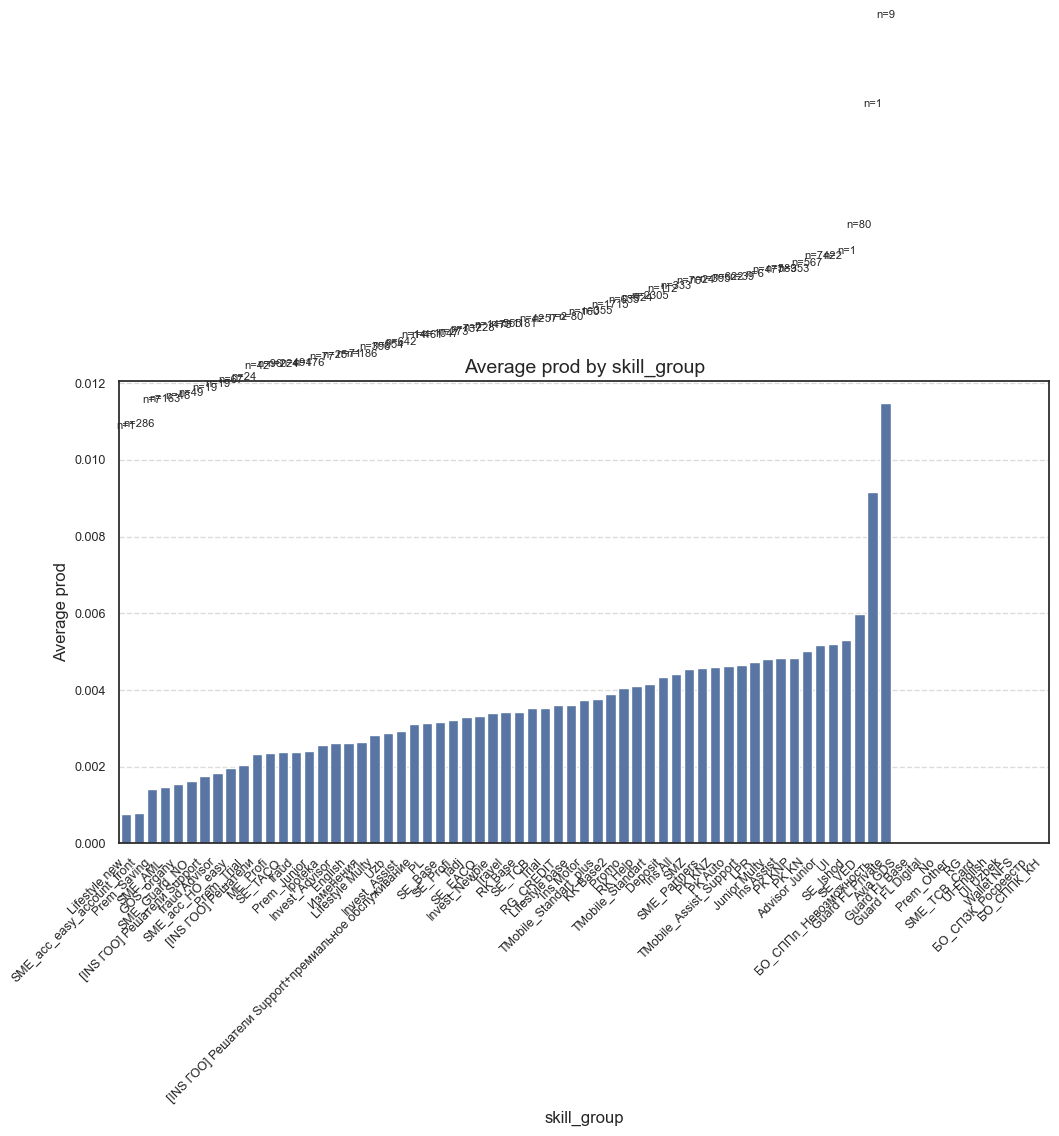

C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Analyzing: emp_type


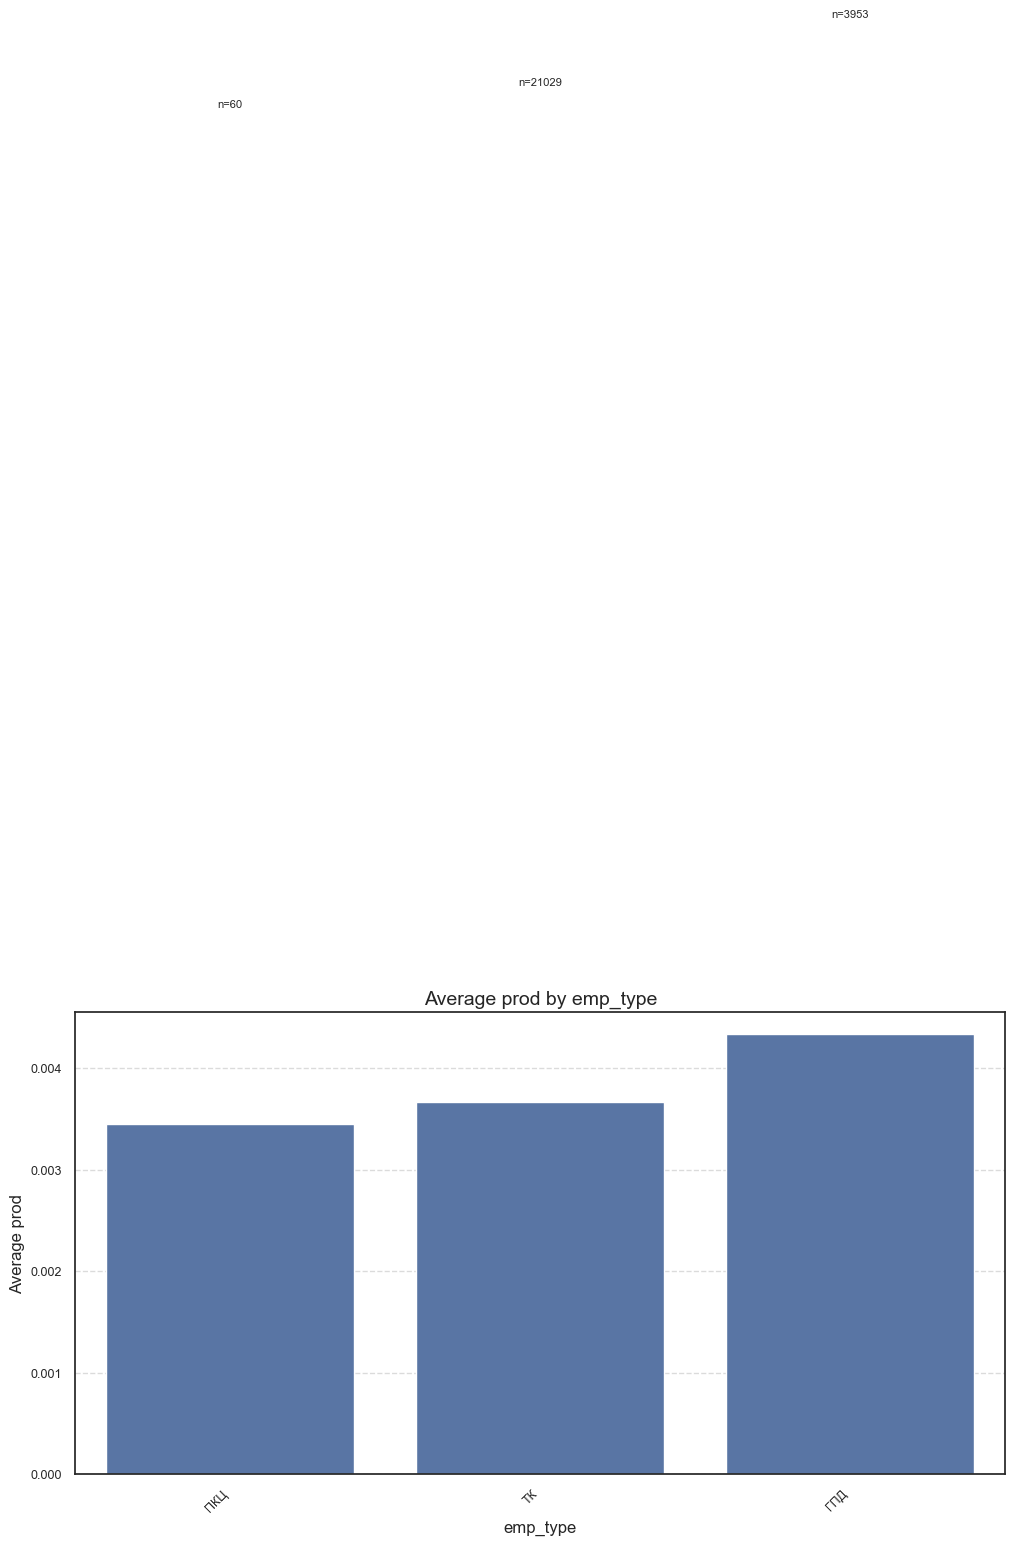

C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
posx and posy should be finite values


Analyzing: hire_dt
Analyzing: exp_staff


posx and posy should be finite values


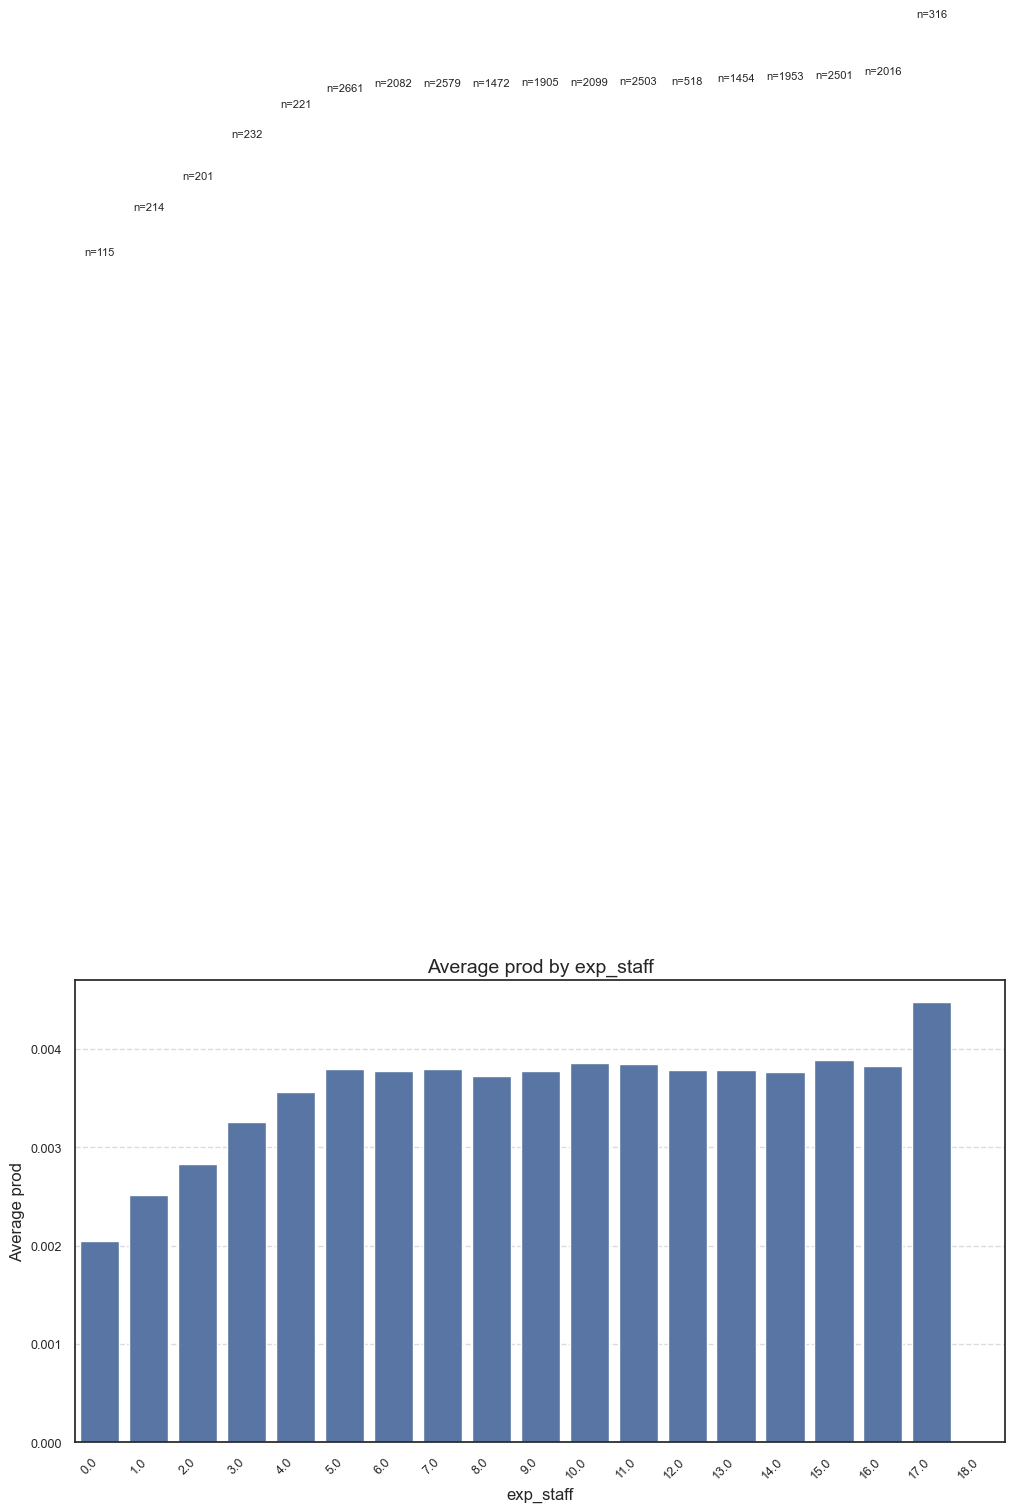

C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Analyzing: gender_desc


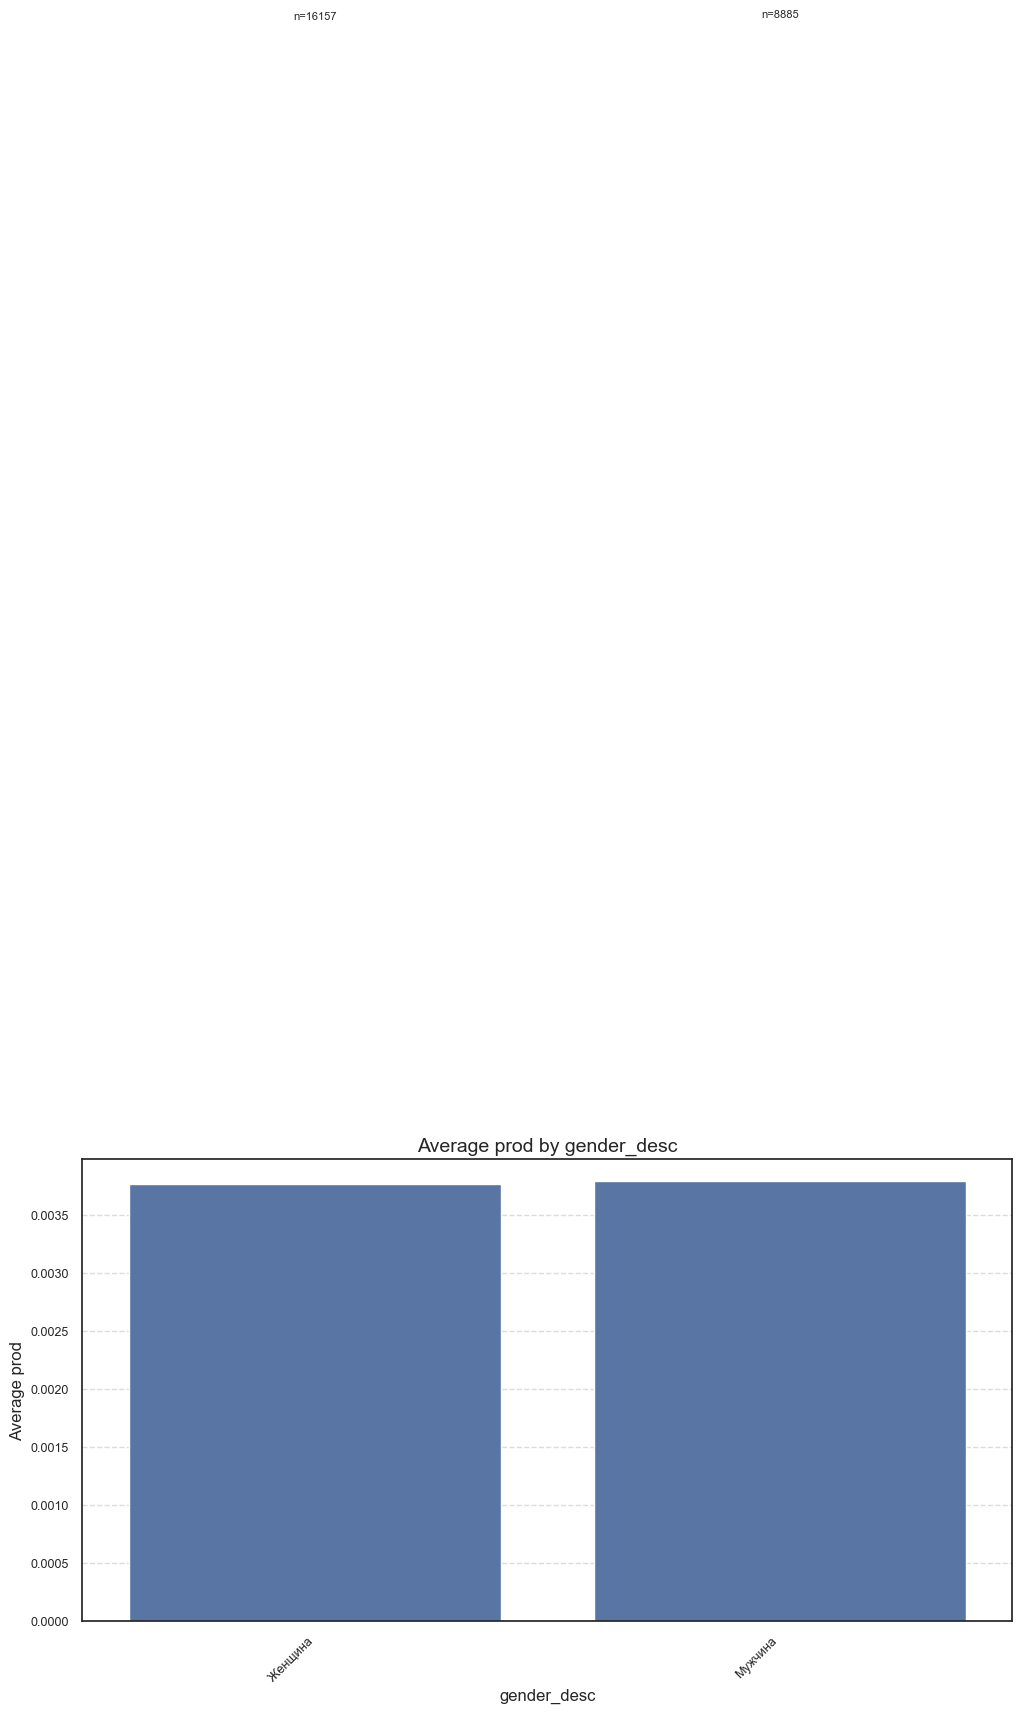

Analyzing: skill_group_exp


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


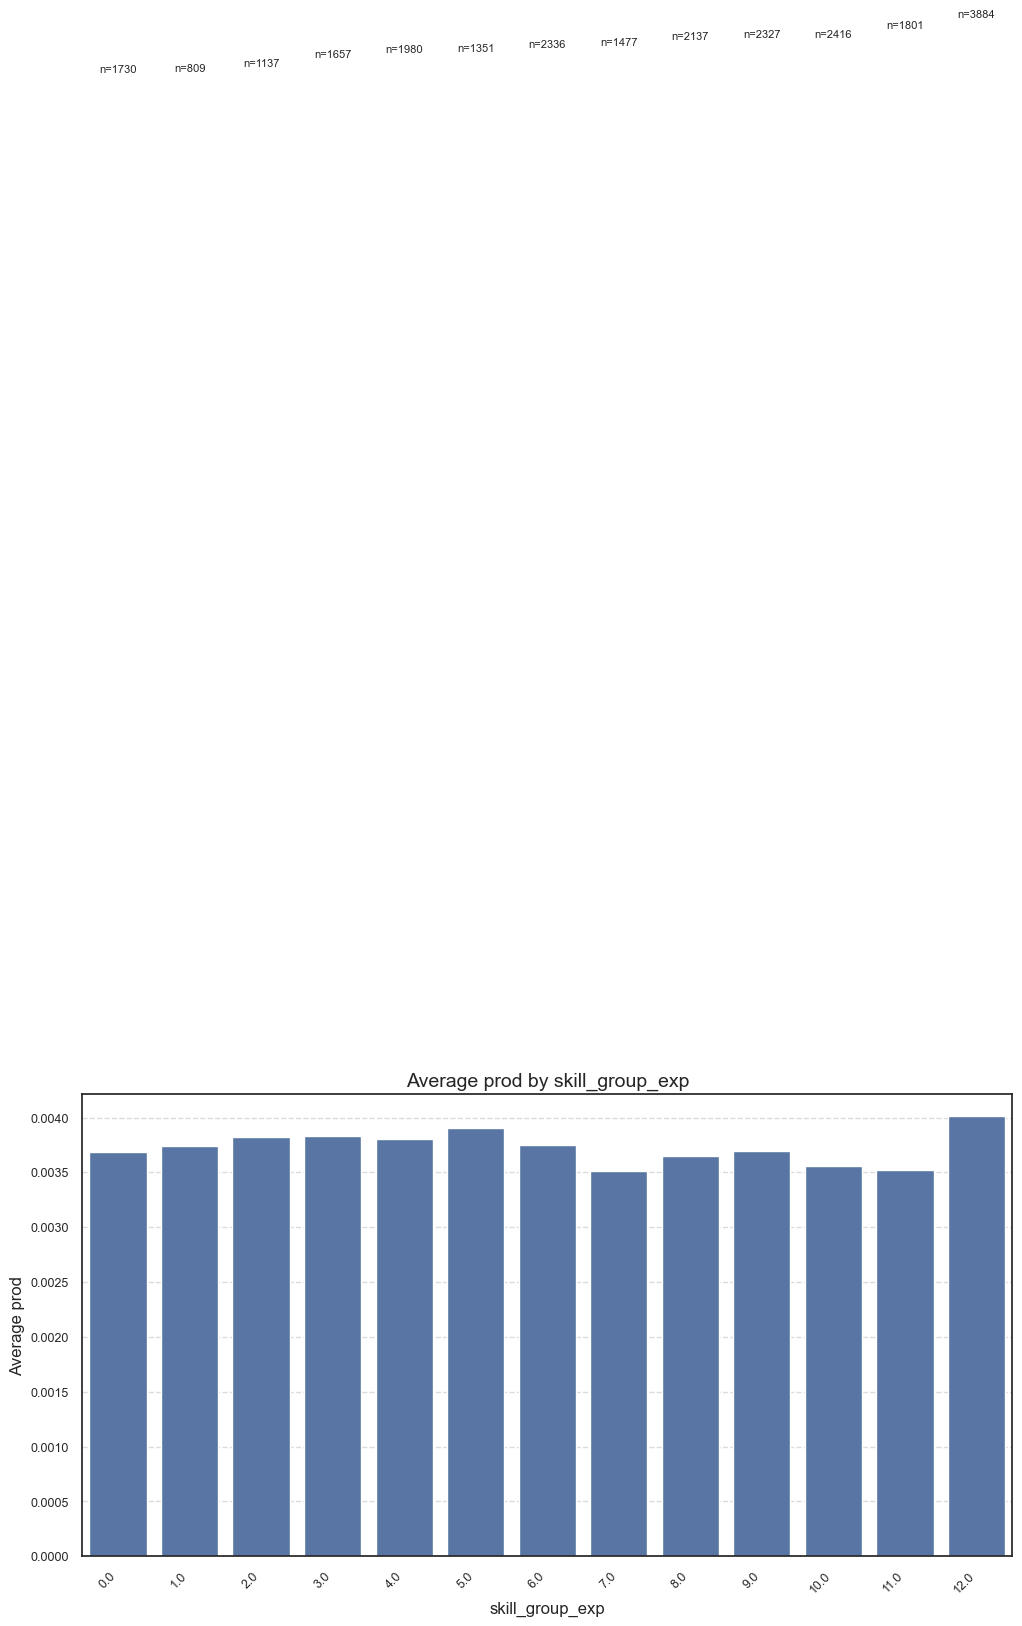

Analyzing: planning_group_nm


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should 

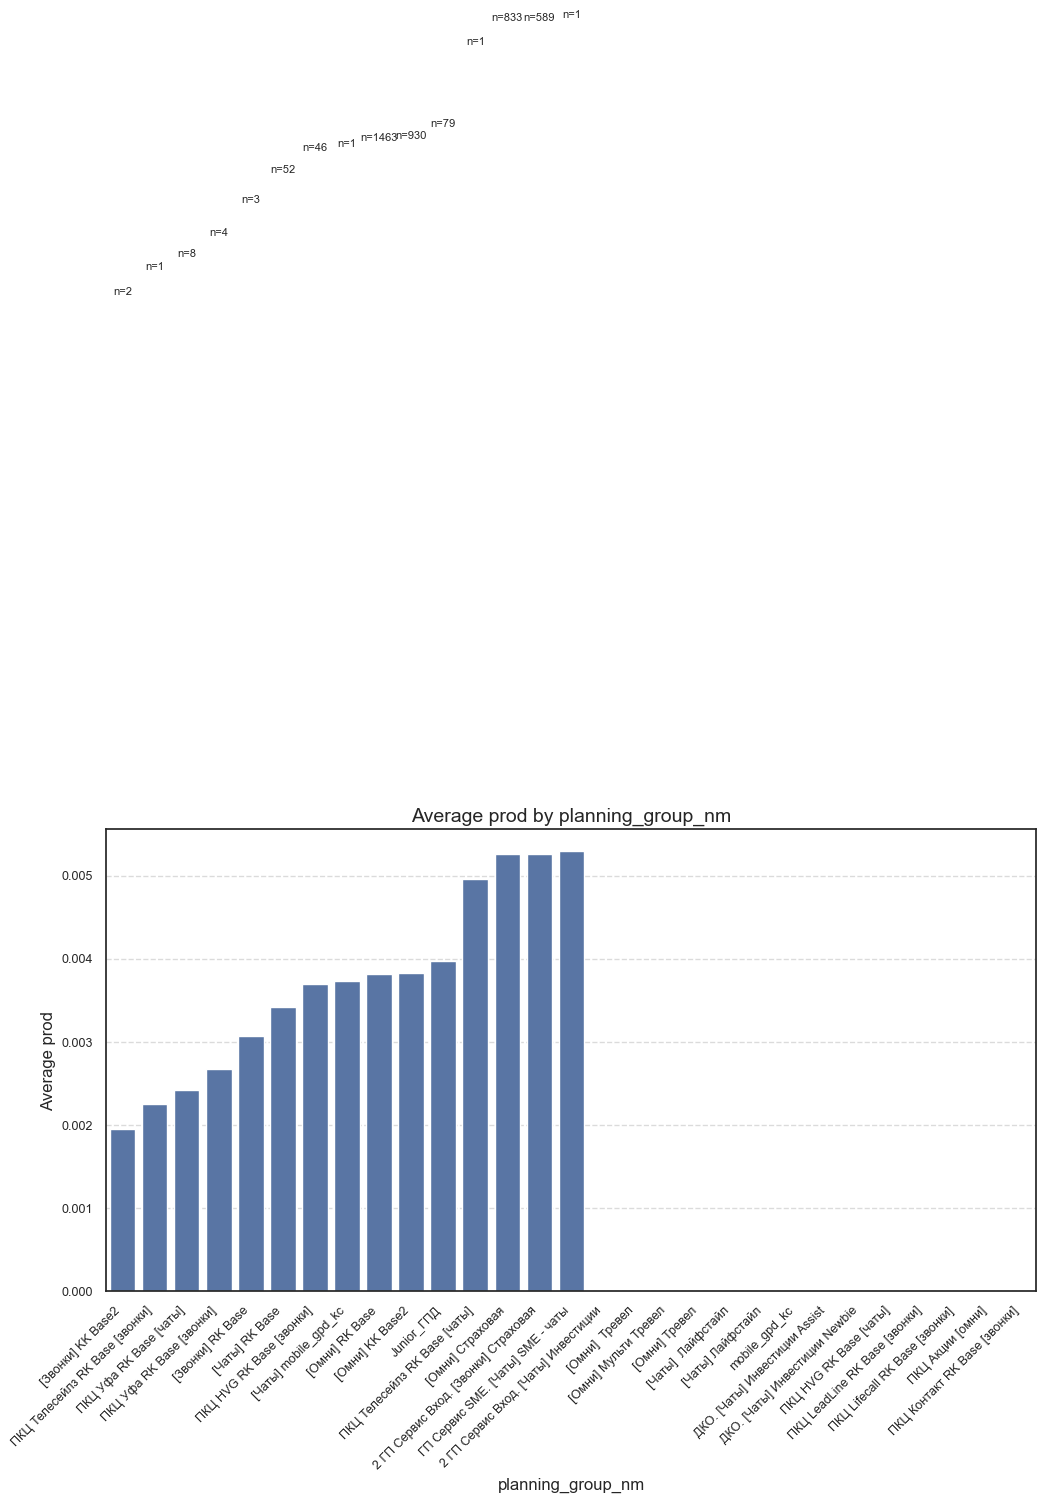

Analyzing: residential_district_nm
Analyzing: residential_city_nm
Analyzing: residential_state_nm


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should 

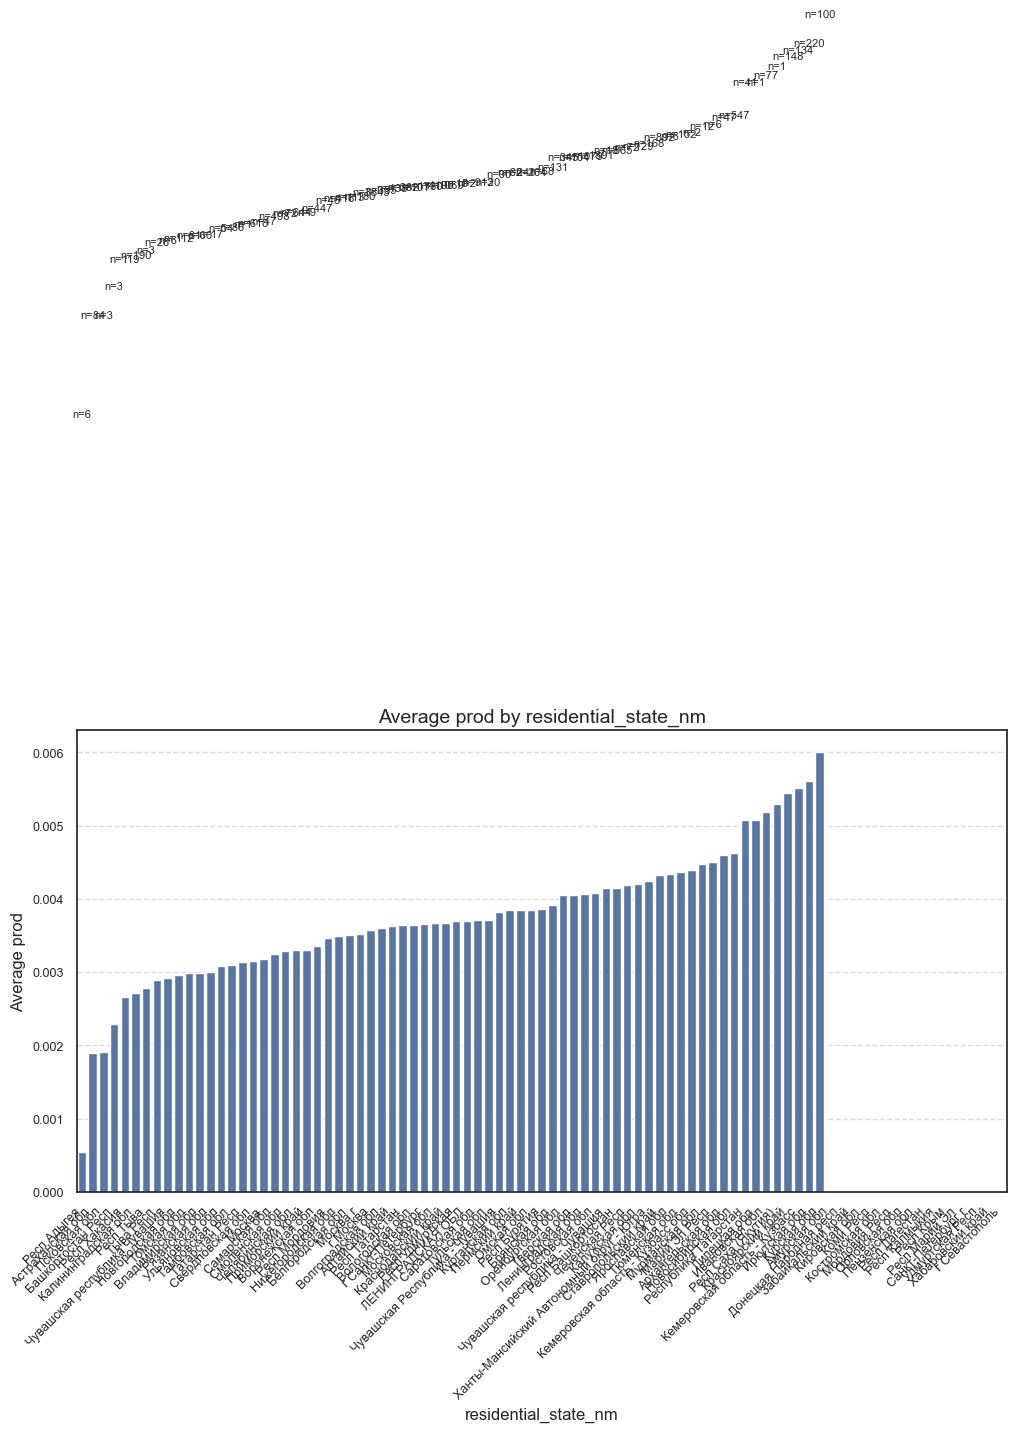

C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Analyzing: residential_settlement_nm
Analyzing: grafik


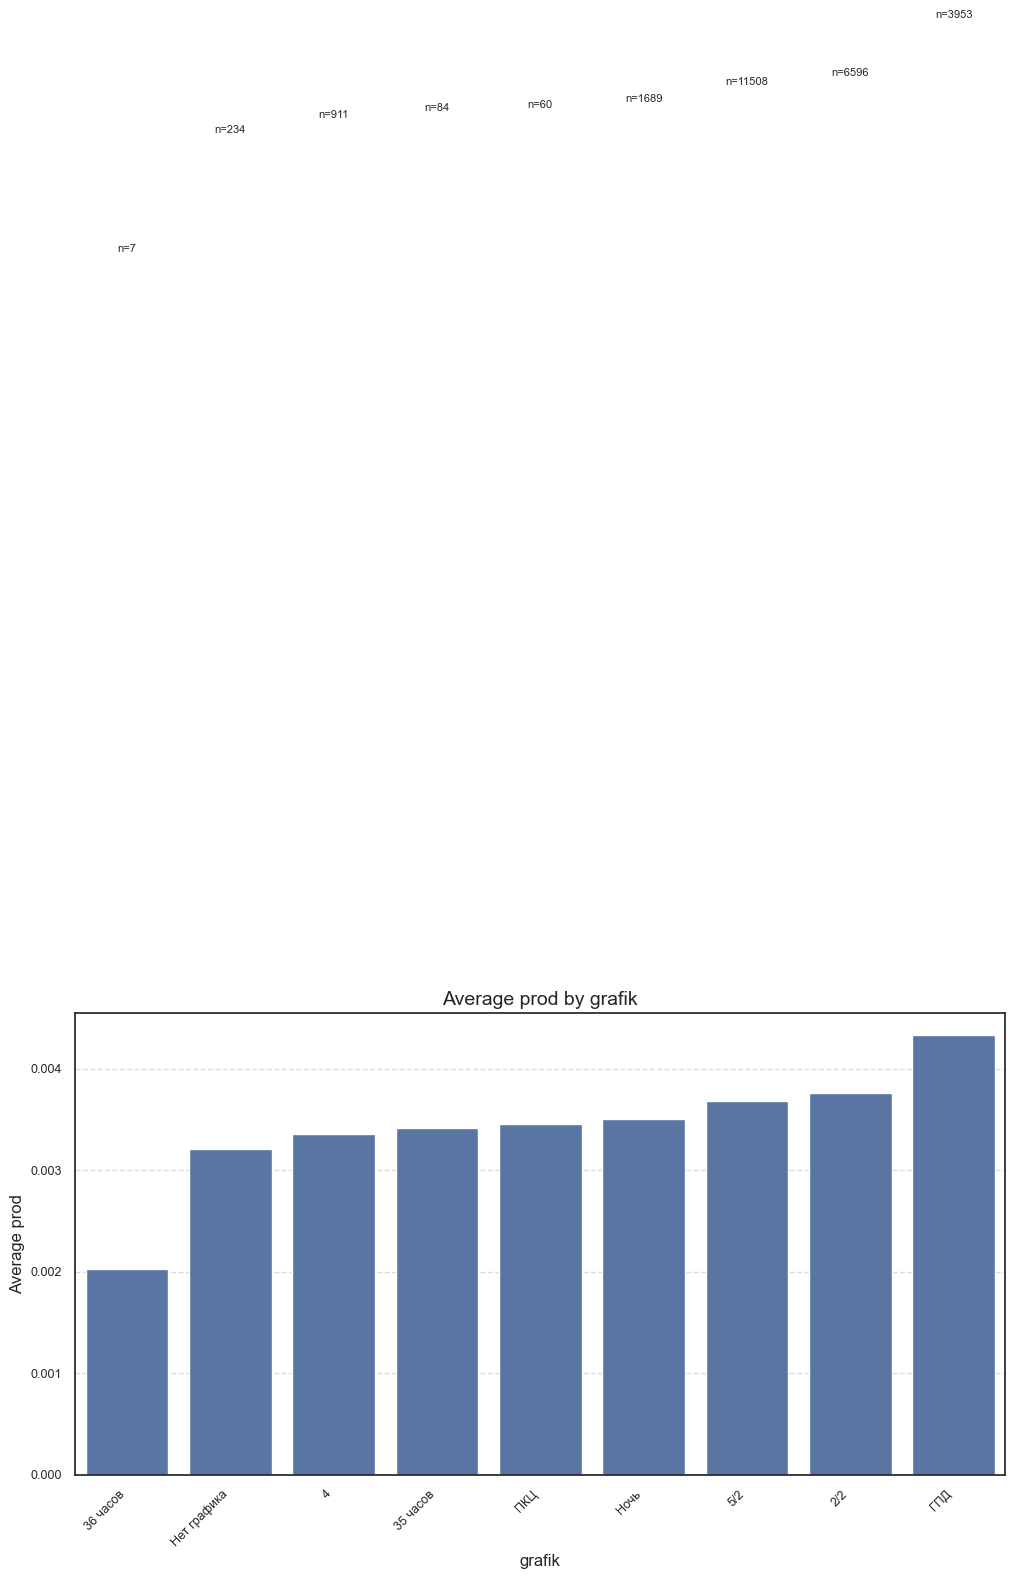

Analyzing: cnt_call
Analyzing: dlg_time_call
Analyzing: cnt_chat
Analyzing: dlg_time_chat
Analyzing: Эффективность
Analyzing: avg_help_time
Analyzing: emp_type_flag


C:\Users\Admin\AppData\Local\Temp\ipykernel_9884\3195693764.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


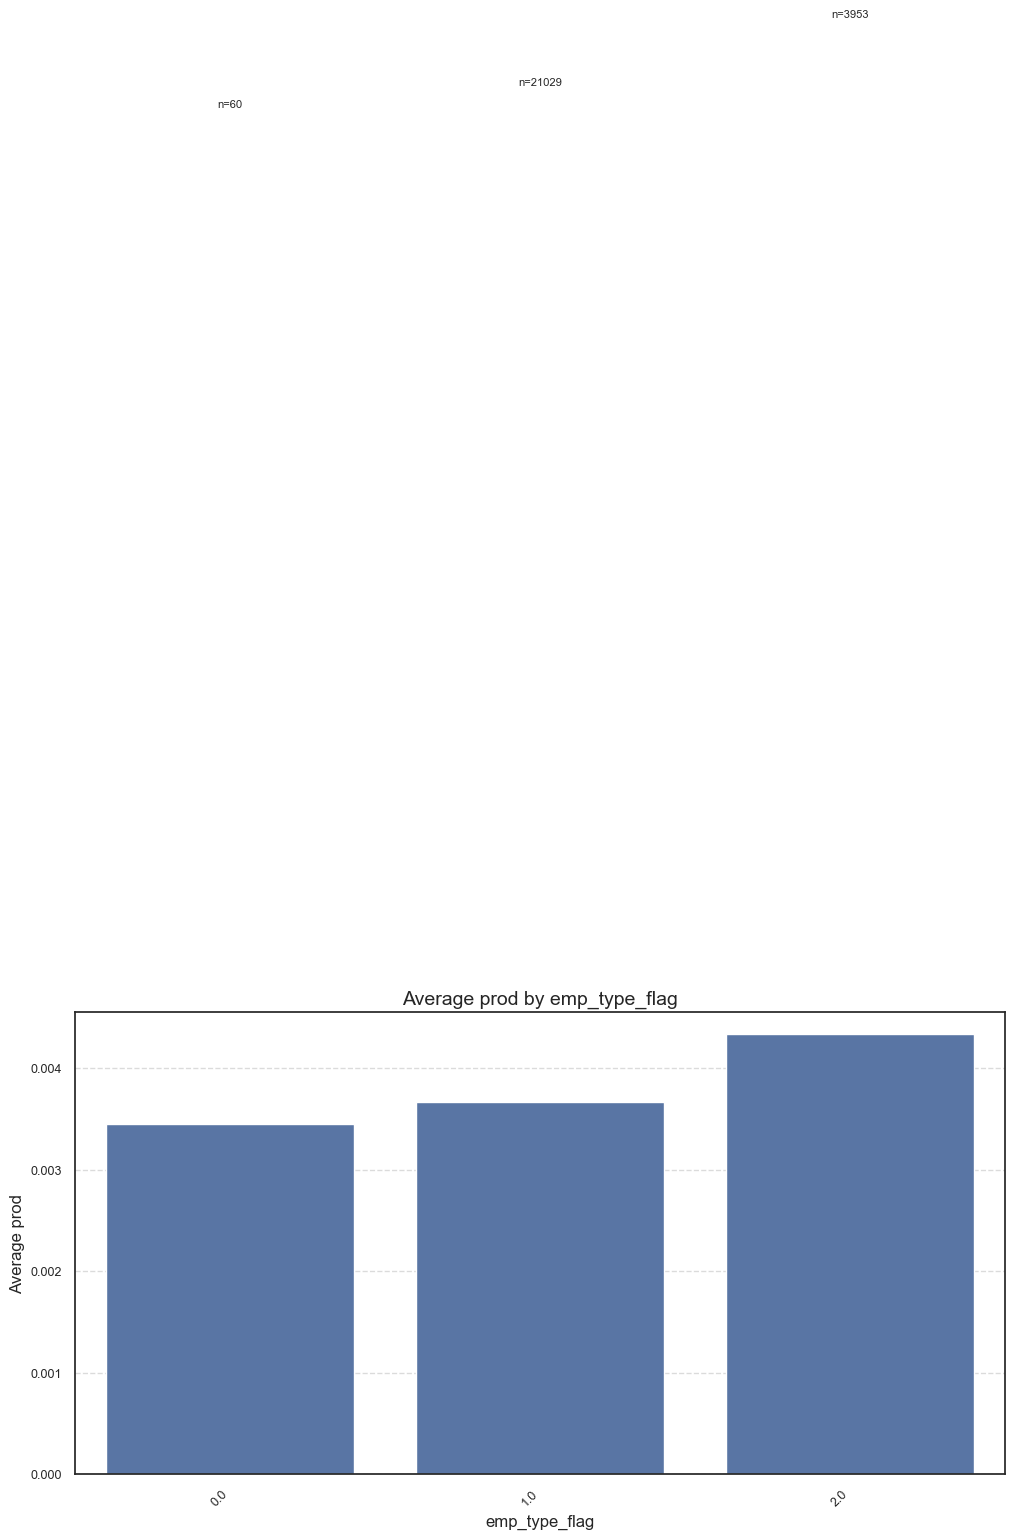

Analyzing: average_work_time


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


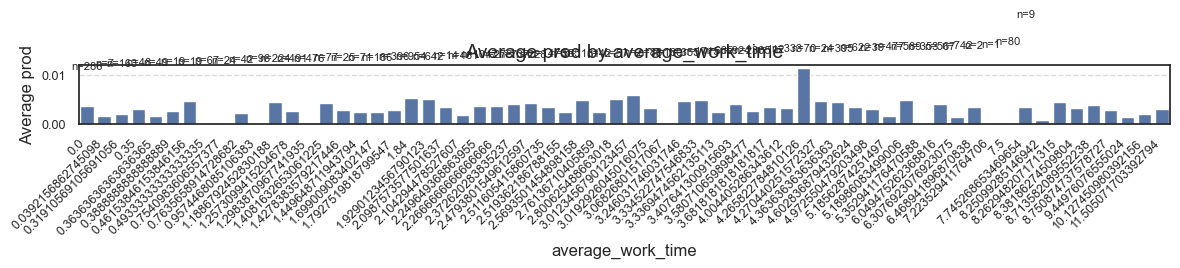

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Загрузка датасета
data = pd.read_excel('data.xlsx')
print(data.head())
# Предположим, что у вас есть столбцы 'полезная_работа' и 'затраченная_энергия'
data['Эффективность'] = (data['useful_calls_fact'] + data['useful_calls_fact'] +  data['avail_calls_fact'] + data['avail_chats_fact'] + data['avail_chat_call_fact'] + data['education_fact'])/(data['useful_calls_fact'] + data['useful_calls_fact'] +  data['avail_calls_fact'] + data['avail_chats_fact'] + data['avail_chat_call_fact'] + data['education_fact'] + data['break_fact'] + data['additional_fact'])

data['Продуктивность'] = (data['cnt_call'] + data['cnt_chat'])/(data['dlg_time_call'] + data['dlg_time_chat'])

data['avg_help_time'] = 1 / data['Продуктивность']

def emp_type_flag(type):
    if type == 'ПКЦ':
        return 0
    elif type == 'ТК':
        return 1
    elif type == 'ГПД':
        return 2

def break_flag(break_fact):
    if break_fact > 0:
        return 1
    return 0

data['emp_type_flag'] = data['emp_type'].apply(emp_type_flag)

data['break_flag'] = data['break_fact'].apply(break_flag)


average_work_time = data.groupby('skill_group')['skill_group_exp'].mean().rename('average_work_time')

# data = data[data['residential_city_nm'] == 'г Москва']
# Добавляем новый столбец в исходный DataFrame
data = data.join(average_work_time, on='skill_group')

print(data.head())

def plot_eff_by_parameter(parameter_column):
    """
    Plot average productivity grouped by values of the given parameter column.
    
    Args:
        parameter_column: The column name to group by
    """
    # Skip if the parameter is 'prod' itself or if it's not a categorical column
    if parameter_column == 'Продуктивность' or data[parameter_column].nunique() > 200:
        return
    
    # Group by the parameter and calculate mean productivity
    grouped_data = data.groupby(parameter_column)['Продуктивность'].agg(['mean', 'count']).reset_index()
    
    # Sort by mean productivity for better visualization
    grouped_data = grouped_data.sort_values('mean')
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    ax = sns.barplot(x=parameter_column, y='mean', data=grouped_data)
    
    # Add count annotations
    for i, row in enumerate(grouped_data.itertuples()):
        ax.text(i, row.mean + 0.01, f"n={row.count}", ha='center', va='bottom', fontsize=8)
    
    # Add labels and title
    plt.title(f'Average prod by {parameter_column}', fontsize=14)
    plt.xlabel(parameter_column, fontsize=12)
    plt.ylabel('Average prod', fontsize=12)
    
    # Rotate x-axis labels if needed
    plt.xticks(fontsize=9, rotation=45, ha='right')
    plt.yticks(fontsize=9)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Loop through all columns and create plots
for column in data.columns:
    if column != 'Продуктивность':  # Skip the productivity column itself
        try:
            print(f"Analyzing: {column}")
            plot_eff_by_parameter(column)
        except Exception as e:
            print(f"Error plotting {column}: {e}")


<Axes: xlabel='Эффективность', ylabel='Продуктивность'>

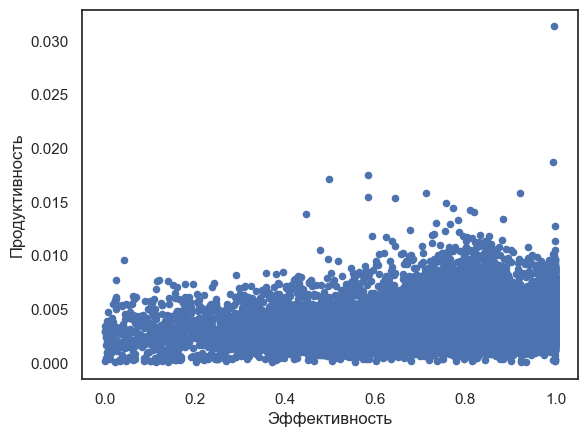

In [32]:
data.plot.scatter(x='Эффективность', y='Продуктивность')

  calendar_dt                       id_employee  useful_calls_fact  \
0  2024-10-22  b85a5824cc3411e3429bd49054ffcc17               1225   
1  2024-10-22  611677896b031565a86d510977572ddf                  0   
2  2024-09-20  3506d80afbdc2f1ddcee2ce65e7d82ee                  0   
3  2024-12-25  a497350c6c8542c1e79ae2b83e6c782d              11483   
4  2024-09-20  34f30cdf1ab7f0195a74ef15963c29a5               1426   

   useful_chats_fact  avail_calls_fact  avail_chats_fact  \
0                  0              2542                 0   
1                  0                 0                 0   
2              21235                 0               372   
3              27466                 3               130   
4              30649               184              2119   

   avail_chat_call_fact  break_fact  education_fact  additional_fact  ...  \
0                     0           0           27598                0  ...   
1                     0           0               0             

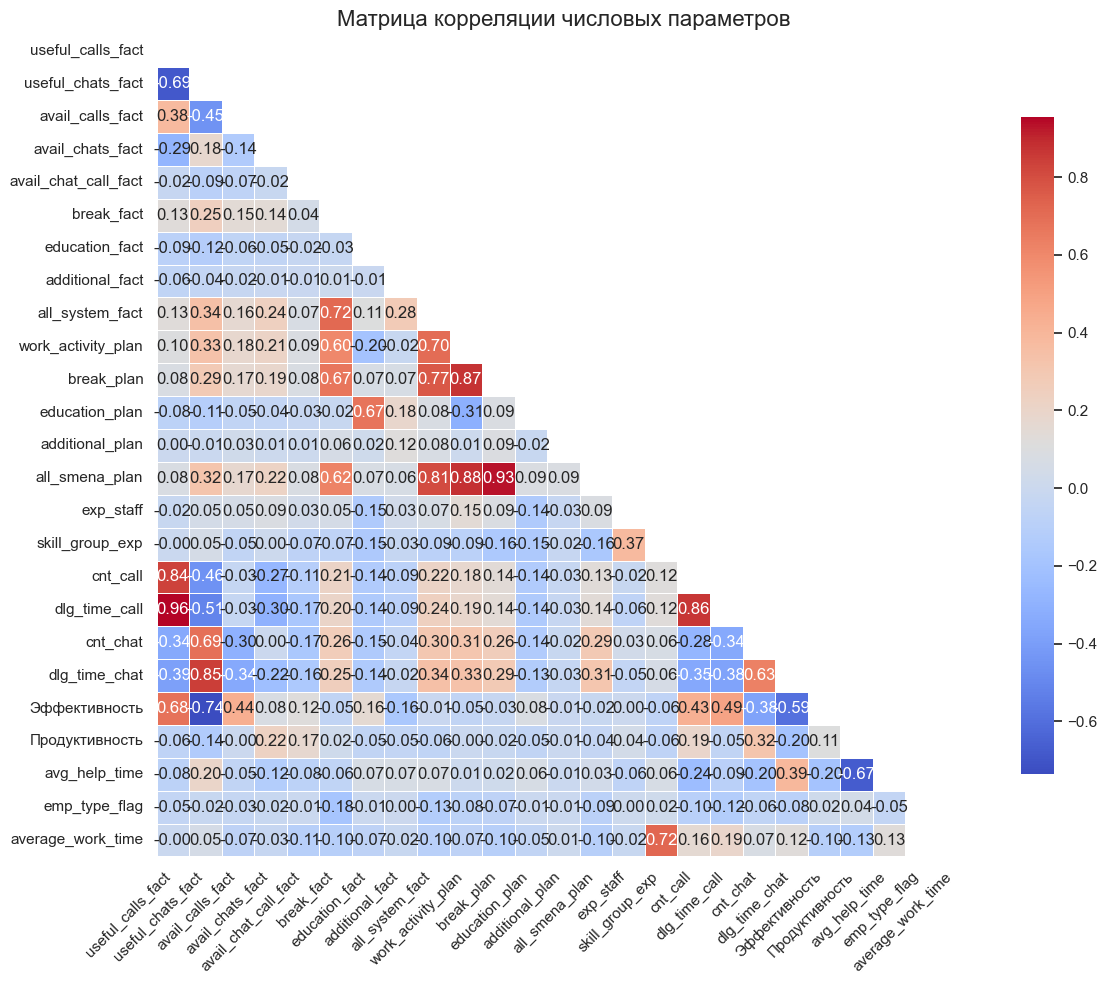

In [34]:
data1 = data[data['break_fact'] > 0]
# data1 = data
print(data.head())
numeric_columns = data1.select_dtypes(include=['number'])

# Вычисляем корреляционную матрицу
corr_matrix = numeric_columns.corr()

# Визуализация
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника

# Используем heatmap из seaborn для лучшей визуализации
import seaborn as sns
sns.set_theme(style="white")
sns.heatmap(corr_matrix, 
            annot=True,  # Показывать значения
            fmt='.2f',   # Формат значений (2 знака после запятой)
            cmap='coolwarm',  # Цветовая схема
            mask=mask,   # Применяем маску для отображения только нижнего треугольника
            linewidths=0.5,  # Ширина линий между ячейками
            cbar_kws={"shrink": .8})  # Настройка цветовой шкалы

plt.title('Матрица корреляции числовых параметров', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()